# PREDICTING MEDICAL COSTS WITH REGRESSION MODELS

In this notebook we will look at samples of medical costs of hospital patients along with other variables such as age, sex, body mass index, smoker status. 

Once a thorough exploratory data analysis is completed, various machine learning models will be implemented to predict medical costs using the feature variables contained within the dataset. 

Thank you for taking the time to view this kernel and please offer any feedback.

-Milton Suggs

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>

1. [Libraries & Packages](#libraries)
2. [Initial Insights](#insights)
3. [Data Preprocessing & Feature Engineering](#preprocessing)
4. [Exploratory Data Analysis](#explore)
5. [Feature Selection](#features)  
6. [Model Building](#models)  
    A. [Multiple Linear Regression](#lr)  
    B. [Ridge Regression](#ridge)  
    C. [Lasso Regression](#lasso)  
    D. [Random Forest Regression](#rf)  
    E. [Polynomial Regression](#poly)  
7. [Model Evaluation](#modeleval)
8. [Conclusion](#conclusion) 

<a id="libraries"></a>
## IMPORT LIBARARIES AND PACKAGES

In [248]:
!pip install seaborn
!pip install chart_studio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [249]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import math  


# Plotly Packages
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)



import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


<a id="insights"></a>
## INITIAL INSIGHTS

In [250]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [252]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [253]:
# VIEW CORRELATION BETWEEN EACH FEATURE TO THE TARGET VARIABLE (CHARGES)

df.corr()['charges'].sort_values().to_frame()

,charges
children,0.067998
bmi,0.198341
age,0.299008
charges,1.000000


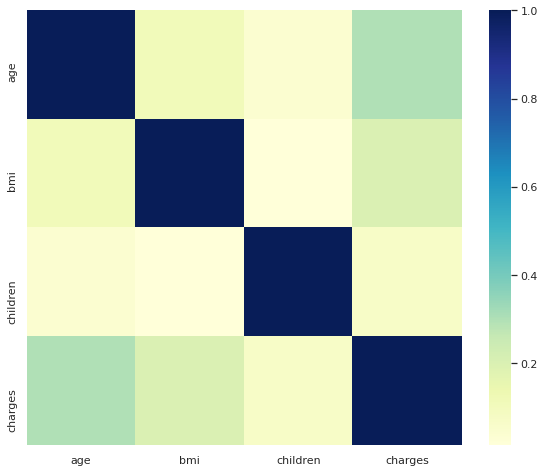

In [254]:
# CREATE HEATMAP TO VIEW CORRELATIONS

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='YlGnBu', square=True, ax=ax)

<a id="preprocessing"></a>
## DATA PREPROCESSING & FEATURE ENGINEERING

**Create new feature "Age Range" from the Age feature**<br>
  * young adult: 18 - 35
  * middle age: 36 - 55
  * senior adult: 56+
   
**Create new feature "weight status" from the BMI feature**<br>
  * underweight
  * normal weight
  * overweight
  * obese

In [255]:
df['age'] = df['age'].astype('int') #Convert data type of 'age' to int
df['children'] = df['children'].astype('int') #Convert data type of 'children' to int

#Create new feature 'age_cat' to categorize values from 'age' colummn

df['age_cat'] = np.nan 

for col in [df]:
    col.loc[(col['age'] >= 18) & (col['age'] <= 35), 'age_cat'] = 'young adult'
    col.loc[(col['age'] > 35) & (col['age'] <= 55), 'age_cat'] = 'middle age'
    col.loc[col['age'] > 55, 'age_cat'] = 'senior adult'

    
#Create new feature 'weight_status' to categorize values from 'bmi' colummn

df["weight_status"] = np.nan

for col in [df]:
    col.loc[col["bmi"] < 18.5, "weight_status"] = "underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_status"] = "normal weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_status"] = "overweight"
    col.loc[col["bmi"] >= 30, "weight_status"] = "obese"
    
df.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,weight_status
0,19,female,27.900,0,yes,southwest,16884.92400,young adult,overweight
1,18,male,33.770,1,no,southeast,1725.55230,young adult,obese
2,28,male,33.000,3,no,southeast,4449.46200,young adult,obese
3,33,male,22.705,0,no,northwest,21984.47061,young adult,normal weight
4,32,male,28.880,0,no,northwest,3866.85520,young adult,overweight


<a id="explore"></a>
## **EXPLORATORY DATA ANALYSIS**

In this section we'll perform an extensive exploratory data analyisis to visualize each of the feature variables. Starting with the 'charges' column, which is our target variable, we'll look at the distribution of values throughout the dataset. Afterward we'll perform univariate, bivariate, and multivariate data explorations. 

### VALUE DISTRIBUTION OF CHARGES VARIABLE

In [256]:
# Determine the distribution of charges

charge_dist = df["charges"]
logcharge = np.log(df["charges"])

trace0 = go.Histogram(x=charge_dist,
                      histnorm='probability',
                      name="Charges Distribution",
                      marker = dict(color = '#02919e',)
                     )

trace1 = go.Histogram(x=logcharge,
                      histnorm='probability',
                      name="Charges Distribution using Log",
                      marker = dict(color = '#9e2602')
                     )

fig = make_subplots(rows=2, cols=1,
                    subplot_titles=('Charge Distribution','Log Charge Distribution'),
                    print_grid=False)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)

fig['layout'].update(showlegend=True, title='Charge Distribution', bargap=0.05)

iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

### DISTRIBUTION OF SEX VARIABLE

* There are 1338 total values in the sex column
* The sex column is divided nearly evenly between male and female with **662 females** and **676 males**

In [257]:
df['sex'].shape

(1338,)

In [258]:
fig = px.histogram(df, x="sex")
fig.show()

## DISTRIBUTION OF SMOKER

* The number of **non-smokers (1064)** far outweighs the number of **smokers (274)** with non-smokers accounting for nearly 80% of the dataset to the smokers 20%.


In [259]:
fig = px.histogram(df, x="smoker", title='SMOKER DISTRIBUTION')
fig.show()

In [260]:
print('Percentage of smokers:\n ', df.smoker.value_counts() / len(df))

Percentage of smokers:
  no     0.795217
yes    0.204783
Name: smoker, dtype: float64


### DISTRIBUTION OF AGE & AGE_CAT VARIABLE

* The majority of samples are in the range of age 36 to 64 years split fairly evenly between the categories "middle age" and "senior adult". 
* The young adult population is far less 16.1% of the dataset consisting of people ages 35 and below.

In [261]:
fig = ff.create_distplot([df['age']], ['age'], bin_size=1, colors=['blue'])
fig.update_layout(title_text="Distribution of Age", title_x=0.5)
fig.show()

In [262]:
labels = df['age_cat'].unique()
values = df['age_cat'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             hoverinfo='label+percent', 
                             textinfo='value+percent', 
                             textfont=dict(size=14))])
fig.update_layout(title_text="Distribution of Age Categories", title_x=0.5)
fig.show()

### DISTRIBUTION OF BMI & WEIGHT STATUS

* Overweight and obese people make up the vast majority of the dataset
* 52.8% of the population is considered **overweight**
* 28.8% of the population is considered **obese**
* Collectively the **normal weight** and **underweight** population make up about 18% of the data

In [263]:
#DISTRIBUTION OF BODY MASS INDEX

fig = ff.create_distplot([df['bmi']], ['bmi'], bin_size=1, colors=['#c97318'])
fig.update_layout(title_text="Distribution of BMI", title_x=0.5)
fig.show()

In [264]:
labels = df['weight_status'].unique()
values = df['weight_status'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             hoverinfo='label+percent', 
                             textinfo='value+percent', 
                             textfont=dict(size=14))])

fig.update_layout(title_text="Distribution of Weight Status", title_x=0.5)
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))

fig.show()

## DISTRIBUTION OF REGION

The four regions **northeast**, **northwest**, **southeast**, **southwest** are fairly evenly distributed throughout the dataset. 

In [265]:
fig = px.histogram(df, x="region")
fig.show()

### DISTRIBUTION OF CHILDREN VARIABLE

* The majority of people have 0 children, while a very small percentage have 4 or more. 
* It doesn't seem likely that number of children will have any significant effect on charges. 

In [266]:
labels = df['children'].sort_values().unique()
values = df['children'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             hoverinfo='label+percent', 
                             textinfo='value+percent', 
                             textfont=dict(size=14),
                             pull=[0.00, 0.00, 0.00, 0.00, 0.2, 0.3, 0.1])])

fig.update_layout(title_text="Distribution of Children", title_x=0.5)
fig.show()

## BIVARIATE & MULTIVARIATE DATA EXPLORATIONS

In this section we will visualize correlations between two variables. Becuase the 'smoker' variable is the most highly correlated with the 'charges' variable we will begin by exploring the relationship between 'smoker' and other variables such as 'age', 'bmi' & 'weight status', and 'region'

### SMOKER STATUS BY SEX

* The number of male smokers (159) outweights the number of female smokers (115)
* Approx 23.5% of male patients are smokers as compared to 17.4% of female patients

In [267]:
s_f = df[(df['smoker'] == 'yes') & (df['sex'] == 'female')]
s_m = df[(df['smoker'] == 'yes') & (df['sex'] == 'male')]

ns_f = df[(df['smoker'] == 'no') & (df['sex'] == 'female')]
ns_m = df[(df['smoker'] == 'no') & (df['sex'] == 'male')]

fig = go.Figure(data=[go.Bar(name='Female', x=df['smoker'].unique(), y=[len(s_f), len(ns_f)]),
                      go.Bar(name='Male', x=df['smoker'].unique(), y=[len(s_m), len(ns_m)]),
                     ]
               )

# Change the bar mode
fig.update_layout(barmode='group', title_text = "Smoker Status by Sex")
fig.show()

In [268]:
labels = df['smoker'].sort_values().unique()
values_f = df['smoker'].loc[df['sex'] == 'female'].value_counts()
values_m = df['smoker'].loc[df['sex'] == 'male'].value_counts()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels, values=values_f, name='Female Smokers'), 1,1)
fig.add_trace(go.Pie(labels=labels, values=values_m, name='Male Smokers'), 1,2)

fig.update_traces(hole=.4, hoverinfo="label+percent+name", textinfo='value+percent')

fig.update_layout(title_text="Smokers by Sex")
fig.show()

### SMOKER STATUS BY AGE AND AGE CATEGORY

* The number of smokers age 19 appears to be significantly more than those of other ages
* The percentage of smokers belonging to each age category is between 18% to 21%

In [269]:
ages = df['age'].loc[df['smoker'] == 'yes']

fig = ff.create_distplot([ages], ['age'], bin_size=1, colors=['#c97318'])
fig.update_layout(title_text="Distribution of smoker ages", title_x=0.5)
fig.show()

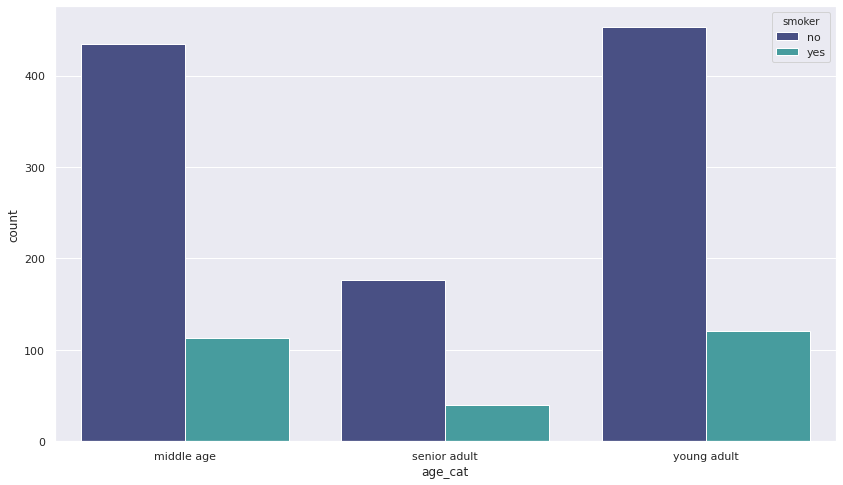

In [270]:
smoker_age = df.groupby(['age_cat','smoker'])['smoker'].count().to_frame()
smoker_age.rename(columns={smoker_age.columns[0]: 'count'}, inplace=True)
smoker_age = smoker_age.reset_index()

plt.figure(figsize=(14,8))
sns.barplot(x='age_cat', y='count', hue='smoker', palette='mako', data=smoker_age)

In [271]:
labels = df['smoker'].sort_values().unique()
values_ya = df['smoker'].loc[df['age_cat'] == 'young adult'].value_counts()
values_ma = df['smoker'].loc[df['age_cat'] == 'middle age'].value_counts()
values_sa = df['smoker'].loc[df['age_cat'] == 'senior adult'].value_counts()

fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=['Young Adult', 'Middle Age', 'Senior Adult'])

fig.add_trace(go.Pie(labels=labels, values=values_ya, name='Young Adult Smokers'), 1,1)
fig.add_trace(go.Pie(labels=labels, values=values_ma, name='Middle Age Smokers'), 1,2)
fig.add_trace(go.Pie(labels=labels, values=values_sa, name='Senior Adult Smokers'), 1,3)

fig.update_traces(hole=.4, hoverinfo="label+percent+name", textinfo='value+percent')

fig.update_layout(title_text="Smoker Percentages by Age Categories")
fig.show()

### SMOKER STATUS BY WEIGHT STATUS

* Obese people are the most present within the dataset while underweight people are the least. 
* In all weight classes, smokers make up about 19% to 25% of the population. 

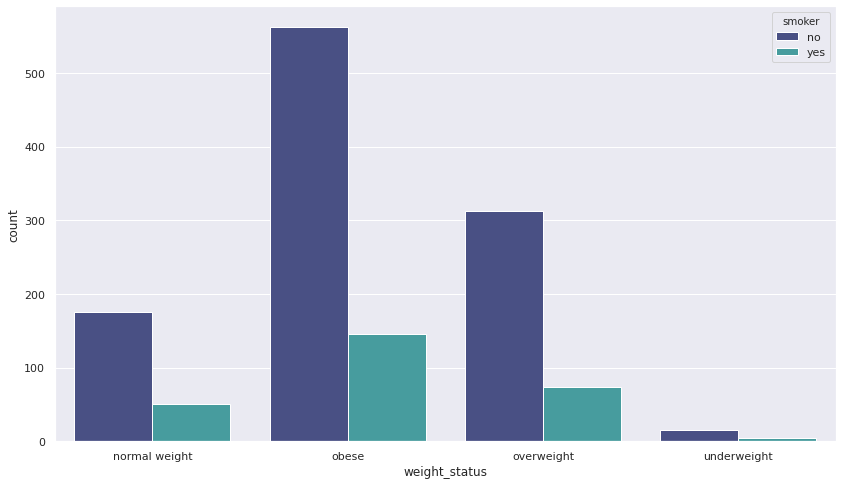

In [272]:
smoker_weight = df.groupby(['weight_status','smoker'])['smoker'].count().to_frame()
smoker_weight.rename(columns={smoker_weight.columns[0]: 'count'}, inplace=True)
smoker_weight = smoker_weight.reset_index()

plt.figure(figsize=(14,8))
sns.barplot(x='weight_status', y='count', hue='smoker', palette='mako', data=smoker_weight)

In [273]:
labels = df['smoker'].sort_values().unique()
values_uw = df['smoker'].loc[df['weight_status'] == 'underweight'].value_counts()
values_nw = df['smoker'].loc[df['weight_status'] == 'normal weight'].value_counts()
values_ow = df['smoker'].loc[df['weight_status'] == 'overweight'].value_counts()
values_ob = df['smoker'].loc[df['weight_status'] == 'obese'].value_counts()

fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=['Underweight', 'Normal Weight', 'Overweight', 'Obese'])

fig.add_trace(go.Pie(labels=labels, values=values_uw, name='Underweight Smokers'), 1,1)
fig.add_trace(go.Pie(labels=labels, values=values_nw, name='Normal Weight Smokers'), 1,2)
fig.add_trace(go.Pie(labels=labels, values=values_ow, name='Overweight Smokers'), 2,1)
fig.add_trace(go.Pie(labels=labels, values=values_ob, name='Obese Smokers'), 2,2)

fig.update_traces(hoverinfo="label+percent+name", textinfo='value+percent')

fig.update_layout(title_text="Smoker Percentages by Weight Status")
fig.show()

### SMOKER STATUS BY REGION

Text(0.5, 1.0, 'Smoker Status by Region')

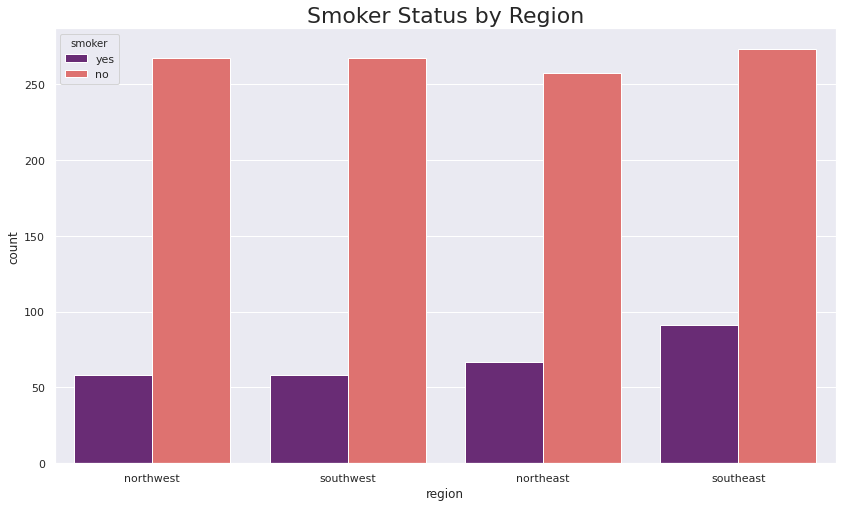

In [274]:
regions = df.groupby(['region', 'smoker'])['region'].count().to_frame()
regions.rename(columns={regions.columns[0]: 'count'}, inplace=True)
regions = regions.reset_index()
regions = regions.sort_values(by='count')

plt.figure(figsize=(14,8))
sns.barplot(x='region', y='count', hue='smoker', palette='magma', data=regions)
plt.title('Smoker Status by Region', fontsize=22)


### SMOKER STATUS BY NUMBER OF CHILDREN

* number of children does not appear to have any influence on smoker status

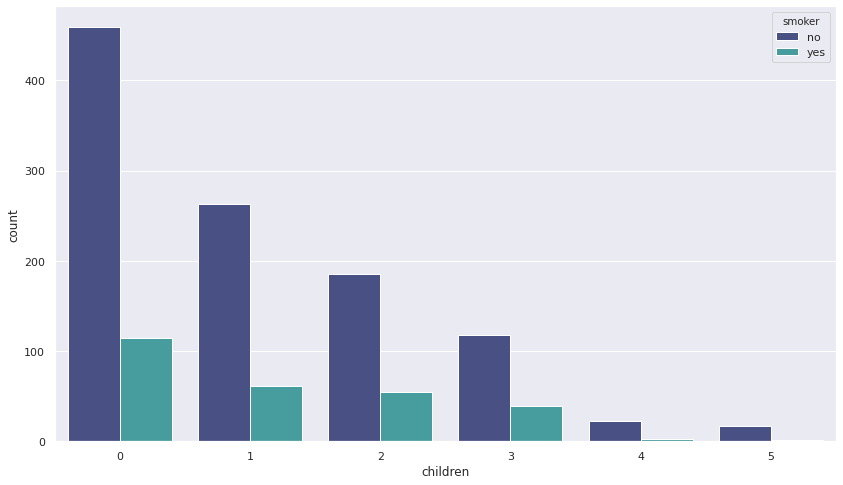

In [275]:
smoker_children = df.groupby(['children','smoker'])['smoker'].count().to_frame()
smoker_children.rename(columns={smoker_children.columns[0]: 'count'}, inplace=True)
smoker_children = smoker_children.reset_index()

plt.figure(figsize=(14,8))
sns.barplot(x='children', y='count', hue='smoker', palette='mako', data=smoker_children)

### BMI DISTRIBUTION BY AGE

* Body mass index and weight status appears to be fairly evenly distributed across all age categories. 
* Senior adults tend to have a slightly higher BMI while young adults tend to have a slightly lower BMI

In [276]:
# BODY MASS INDEX AND AGE

fig = px.scatter(df, x='age', y='bmi', color='weight_status')
fig.update_layout(title='BMI Distribution by Age')
fig.show()

### BODY MASS INDEX AND AGE CATEGORY

In [277]:
young_adults = df["bmi"].loc[df["age_cat"] == "young adult"].values
senior_adult = df["bmi"].loc[df["age_cat"] == "middle age"].values
elders = df["bmi"].loc[df["age_cat"] == "senior adult"].values

trace0 = go.Box(y=young_adults,
                name = 'Young Adults',
                boxmean= True,
                marker = dict(color = 'rgb(214, 12, 140)')
               )

trace1 = go.Box(y=senior_adult,
                name = 'Middle Age',
                boxmean= True,
                marker = dict(color = 'rgb(0, 128, 128)')
               )

trace2 = go.Box(y=elders,
                name = 'Senior Adults',
                boxmean= True,
                marker = dict(color = 'rgb(247, 186, 166)')
               )


data = [trace0, trace1, trace2]

layout = go.Layout(title="Body Mass Index by Age Category", 
                   xaxis=dict(title="Age Category", titlefont=dict(size=16)),
                   yaxis=dict(title="Body Mass Index", titlefont=dict(size=16)))

fig = go.Figure(data=data, layout=layout)

iplot(fig)

### WEIGHT STATUS AND AGE CATEGORY

* The Young Adult population is slightly more likely to have a normal weight status than the middle age population. 
* The middle age population is slight more lokely to have an obese weight status than the young adult population. 


young adult     574
middle age      548
senior adult    216
Name: age_cat, dtype: int64


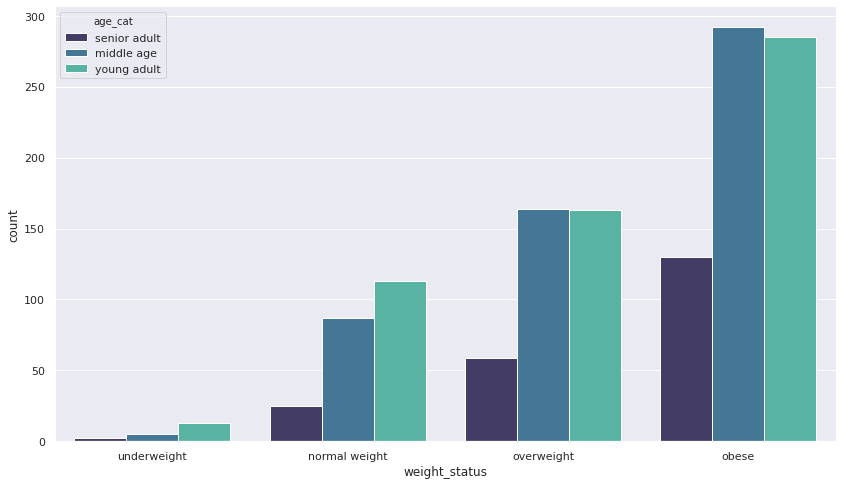

In [278]:
print(df['age_cat'].value_counts())

weights = df.groupby(['weight_status','age_cat'])['age_cat'].count().to_frame()
weights.rename(columns={weights.columns[0]: 'count'}, inplace=True)
weights = weights.reset_index()
weights = weights.sort_values(by='count')

plt.figure(figsize=(14,8))
sns.barplot(x='weight_status', y='count', hue='age_cat', palette='mako', data=weights)


### WEIGHT STATUS PER REGION

* the Northwest region has a significantly higher number of obese people than the other regions

In [279]:
# Obesity per region
region_weight = pd.crosstab(df['weight_status'], df['region']).apply(lambda x: x/x.sum() * 100)
region_weight = round(region_weight, 2)
region_weight

region,northeast,northwest,southeast,southwest
weight_status,,,,
normal weight,22.53,19.38,11.26,14.77
obese,44.14,45.54,66.76,53.23
overweight,30.25,32.92,21.98,31.08
underweight,3.09,2.15,0.00,0.92


In [280]:
ne_under = df[(df['weight_status'] == 'underweight') & (df['region'] == 'northeast')]
ne_normal = df[(df['weight_status'] == 'normal weight') & (df['region'] == 'northeast')]
ne_over = df[(df['weight_status'] == 'overweight') & (df['region'] == 'northeast')]
ne_obese = df[(df['weight_status'] == 'obese') & (df['region'] == 'northeast')]

nw_under = df[(df['weight_status'] == 'underweight') & (df['region'] == 'northwest')]
nw_normal = df[(df['weight_status'] == 'normal weight') & (df['region'] == 'northwest')]
nw_over = df[(df['weight_status'] == 'overweight') & (df['region'] == 'northwest')]
nw_obese = df[(df['weight_status'] == 'obese') & (df['region'] == 'northwest')]

se_under = df[(df['weight_status'] == 'underweight') & (df['region'] == 'southeast')]
se_normal = df[(df['weight_status'] == 'normal weight') & (df['region'] == 'southeast')]
se_over = df[(df['weight_status'] == 'overweight') & (df['region'] == 'southeast')]
se_obese = df[(df['weight_status'] == 'obese') & (df['region'] == 'southeast')]

sw_under = df[(df['weight_status'] == 'underweight') & (df['region'] == 'southwest')]
sw_normal = df[(df['weight_status'] == 'normal weight') & (df['region'] == 'southwest')]
sw_over = df[(df['weight_status'] == 'overweight') & (df['region'] == 'southwest')]
sw_obese = df[(df['weight_status'] == 'obese') & (df['region'] == 'southwest')]

fig = go.Figure(data=[go.Bar(name='Underweight', x=df['region'].unique(), y=[len(ne_under), len(nw_under), len(se_under), len(sw_under)]),
                      go.Bar(name='Normal Weight', x=df['region'].unique(), y=[len(ne_normal), len(nw_normal), len(se_normal), len(sw_normal)]),
                      go.Bar(name='Overweight', x=df['region'].unique(), y=[len(ne_over), len(nw_over), len(se_over), len(sw_over)]),
                      go.Bar(name='Obese', x=df['region'].unique(), y=[len(ne_obese), len(nw_obese), len(se_obese), len(sw_obese)])
                     ]
               )

# Change the bar mode
fig.update_layout(barmode='group', title_text = "Weight Status by Region")
fig.show()

### BODY MASS INDEX OF SMOKERS

In [281]:
bmi_smoker = df["bmi"].loc[(df["smoker"] == "yes")].values
bmi_nonsmoker = df["bmi"].loc[(df["smoker"] == "no")].values

# Smokers
ya_smoker = df["bmi"].loc[(df["age_cat"] == "young adult") & (df["smoker"] == "yes")].values
sa_smoker = df["bmi"].loc[(df["age_cat"] == "middle age") & (df["smoker"] == "yes")].values
e_smoker = df["bmi"].loc[(df["age_cat"] == "senior adult") & (df["smoker"] == "yes")].values

# Non-Smokers
ya_nonsmoker = df["bmi"].loc[(df["age_cat"] == "young adult") & (df["smoker"] == "no")].values
sa_nonsmoker = df["bmi"].loc[(df["age_cat"] == "middle age") & (df["smoker"] == "no")].values
e_nonsmoker = df["bmi"].loc[(df["age_cat"] == "senior adult") & (df["smoker"] == "no")].values

In [282]:
x_data = ['Smoker', 'Non-Smoker']

y0 = bmi_smoker
y1 = bmi_nonsmoker

y_data = [y0,y1]

colors = ['rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
          'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
          'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)']

traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(y=yd, name=xd, boxpoints='all', jitter=0.5, whiskerwidth=0.2,
                             fillcolor=cls, marker=dict(size=2,), line=dict(width=1))
                     )

layout = go.Layout(title='Body Mass Index of Smokers Status by Age Category',
                   xaxis=dict(title="Smoker Status", titlefont=dict(size=16)),
                   yaxis=dict(title="Body Mass Index", autorange=True, showgrid=True, 
                              zeroline=True, dtick=5, gridcolor='rgb(255, 255, 255)',
                              gridwidth=1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2,
                              titlefont=dict(size=16)),
                   margin=dict(l=40,r=30,b=80,t=100,),
                   paper_bgcolor='rgb(255, 255, 255)',
                   plot_bgcolor='rgb(255, 245, 201)',
                   showlegend=False
                  )

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

### AGE CATEGORIES BY REGION

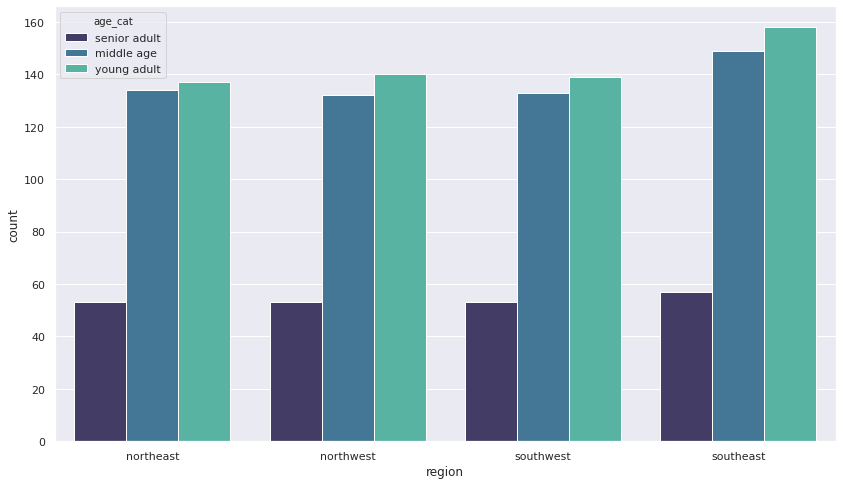

In [283]:
region_age = df.groupby(['region','age_cat'])['age_cat'].count().to_frame()
region_age.rename(columns={region_age.columns[0]: 'count'}, inplace=True)
region_age = region_age.reset_index()
region_age = region_age.sort_values(by='count')

plt.figure(figsize=(14,8))
sns.barplot(x='region', y='count', hue='age_cat', palette='mako', data=region_age)

In [284]:
x_data = ['Young A. Smoker', 'Young A. Non-Smoker',
          'Senior A. Smoker', 'Senior A. Non-Smoker',
          'Elder Smoker', 'Elder Non-Smoker',]

y0 = ya_smoker
y1 = ya_nonsmoker
y2 = sa_smoker
y3 = sa_nonsmoker
y4 = e_smoker
y5 = e_nonsmoker

y_data = [y0,y1,y2,y3,y4,y5]

colors = ['rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
          'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)', 
          'rgba(251, 43, 43, 0.5)', 'rgba(125, 251, 137, 0.5)']

traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(y=yd,
                             name=xd,
                             boxpoints='all',
                             jitter=0.5,
                             whiskerwidth=0.2,
                             fillcolor=cls,
                             marker=dict(size=2,),
                             line=dict(width=1),
                            )
                     )

layout = go.Layout(title='Body Mass Index of Smokers Status by Age Category',
                   xaxis=dict(title="Status", titlefont=dict(size=16)),
                   yaxis=dict(title="Body Mass Index",
                              autorange=True, 
                              showgrid=True, 
                              zeroline=True,
                              dtick=5,
                              gridcolor='rgb(255, 255, 255)',
                              gridwidth=1,
                              zerolinecolor='rgb(255, 255, 255)',
                              zerolinewidth=2,
                              titlefont=dict(size=16)
                             ),
                   margin=dict(l=40,r=30,b=80,t=100,),
                   paper_bgcolor='rgb(255, 255, 255)',
                   plot_bgcolor='rgb(255, 245, 201)',
                   showlegend=False
                  )

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

<hr>

## CHARGES CORRELATIONS

### CHARGES BY SMOKER STATUS

* There is a large difference in charges between smokers and non-smokers
* There is an approximately 27,000USD difference in median charge for smokers (7,345USD) and non-smokers (34,456USD)

In [285]:
fig = px.box(df, x="smoker", y="charges", color='smoker', points="all")
fig.update_layout(title='CHARGES BY SMOKER STATUS')
fig.show()

### CHARGES BY SEX

* Females tend to have lower healthcare charges than their male counterparts.

In [286]:
fig = px.box(df, x="sex", y='charges', color='sex', points="all")
fig.update_layout(title='CHARGES BY SEX')
fig.show()

### CHARGES BY SMOKER STATUS AND SEX

In [287]:
fig = px.violin(df, y="charges", x="smoker", color="sex", box=True, points="all",
          hover_data=df.columns)
fig.show()

### CHARGES DISTRIBUTION BY AGE

* There is a positive correlation between charges and age as there is a slight increase in charges as the ages get higher. 
* The mean and median charges by age category reflect this correlation.
* The distinction in charges between smokers and non-smokers is very clear.

In [288]:
fig = px.scatter(df, x='age', y='charges', color='smoker')
fig.update_layout(title='Charges Distribution by Age')
fig.show()

In [289]:
# Means
avg_charge_ya = df["charges"].loc[df["age_cat"] == "young adult"].mean()
avg_charge_sa = df["charges"].loc[df["age_cat"] == "middle age"].mean()
avg_charge_e = df["charges"].loc[df["age_cat"] == "senior adult"].mean()

# Median
med_charge_ya = df["charges"].loc[df["age_cat"] == "young adult"].median()
med_charge_sa = df["charges"].loc[df["age_cat"] == "middle age"].median()
med_charge_e = df["charges"].loc[df["age_cat"] == "senior adult"].median()

# Determine the distribution of age according to charge

average_plot = go.Bar(x=['young adult', 'middle age', 'senior adult'],
                      y=[avg_charge_ya, avg_charge_sa, avg_charge_e],
                      name='Mean',
                      marker=dict(color="#18b5c9")
                     )

med_plot = go.Bar(x=['young adult', 'middle age', 'senior adult'],
                  y=[med_charge_ya, med_charge_sa, med_charge_e],
                  name='Median',
                  marker=dict(color="#c93318")
                 )

fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]],
                    subplot_titles=('Average Charge by Age','Median Charge by Age'),
                    shared_yaxes=True, print_grid=False)

fig.append_trace(average_plot, 1, 1)
fig.append_trace(med_plot, 1, 2)

fig.update_layout(showlegend=True, 
                  title='MEAN AND MEDIAN CHARGES BY AGE CATEOGRIES', 
                  xaxis=dict(title="Age Category"), 
                  yaxis=dict(title="Patient Charges"), 
                  bargap=0.15)

iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [290]:
fig = px.box(df, x="age_cat", y="charges", color='age_cat', points="all")
fig.show()

### CHARGES BY BMI

In [291]:
fig = px.scatter(df, x='bmi', y='charges', color='smoker')
fig.update_layout(title='Charges by BMI')
fig.show()

In [292]:
# Determine the distribution of charges according to weight status

# Means
avg_charge_uw = df["charges"].loc[df["weight_status"] == "underweight"].mean()
avg_charge_nw = df["charges"].loc[df["weight_status"] == "normal weight"].mean()
avg_charge_ow = df["charges"].loc[df["weight_status"] == "overweight"].mean()
avg_charge_ob = df["charges"].loc[df["weight_status"] == "obese"].mean()

# Median
med_charge_uw = df["charges"].loc[df["weight_status"] == "underweight"].median()
med_charge_nw = df["charges"].loc[df["weight_status"] == "normal weight"].median()
med_charge_ow = df["charges"].loc[df["weight_status"] == "overweight"].median()
med_charge_ob = df["charges"].loc[df["weight_status"] == "obese"].median()



average_plot = go.Bar(x=['Underweight', 'Normal Weight', 'Overweight', 'Obese'],
                      y=[avg_charge_uw, avg_charge_nw, avg_charge_ow, avg_charge_ob],
                      name='Mean',
                      marker=dict(color="#18b5c9")
                     )

med_plot = go.Bar(x=['Underweight', 'Normal Weight', 'Overweight', 'Obese'],
                  y=[med_charge_uw, med_charge_nw, med_charge_ow, med_charge_ob],
                  name='Median',
                  marker=dict(color="#c93318")
                 )

fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]],
                    subplot_titles=('Average Charge by Weight Status','Median Charge by Weight Status'),
                    shared_yaxes=True, print_grid=False)

fig.append_trace(average_plot, 1, 1)
fig.append_trace(med_plot, 1, 2)

fig.update_layout(showlegend=True, 
                  title='Weight Status Charges', 
                  xaxis=dict(title="Weight Status"), 
                  yaxis=dict(title="Patient Charges"), 
                  bargap=0.15)

iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [293]:
fig = px.box(df, x="weight_status", y="charges", color='weight_status', points="all")
fig.update_layout(title='ALL CHARGES BY WEIGHT STATUS')
fig.show()

### CHARGES BY AGE CATEGORY & SMOKER STATUS

In [294]:
fig = go.Figure()

fig.add_trace(go.Violin(x=df['age_cat'][ df['smoker'] == 'yes' ],
                        y=df['charges'][ df['smoker'] == 'yes' ],
                        legendgroup='Yes', scalegroup='Yes', name='Yes',
                        side='negative',
                        line_color='blue')
             )

fig.add_trace(go.Violin(x=df['age_cat'][ df['smoker'] == 'no' ],
                        y=df['charges'][ df['smoker'] == 'no' ],
                        legendgroup='No', scalegroup='No', name='No',
                        side='positive',
                        line_color='orange')
             )

fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_layout(title='CHARGES BY AGE CATEGORY & SMOKER STATUS', violinmode='group')
fig.show()

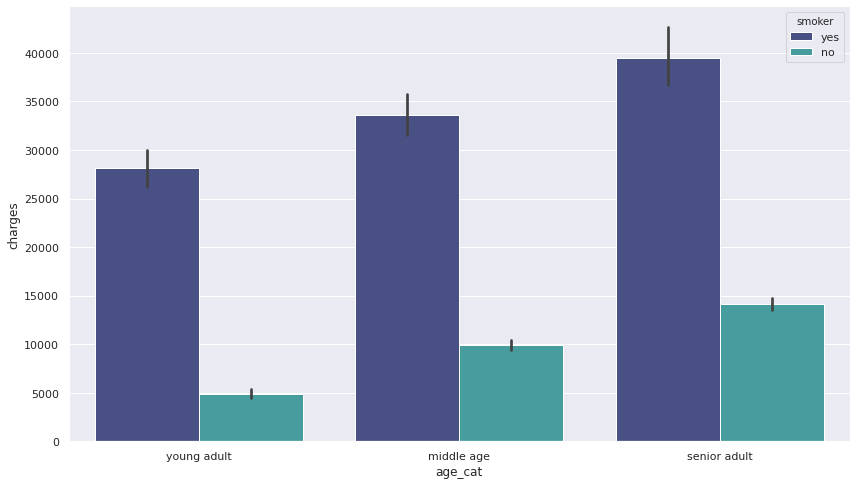

In [295]:
plt.figure(figsize=(14,8))
sns.barplot(x='age_cat', y='charges', hue='smoker', palette='mako', data=df)

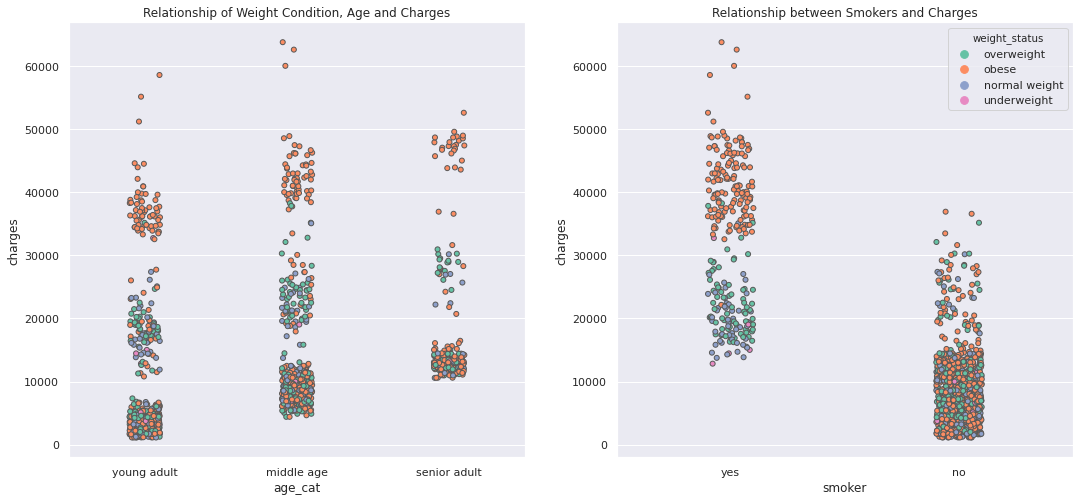

In [296]:
# Create subpplots
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8))

sns.stripplot(x="age_cat", y="charges", hue="weight_status", data=df, ax=ax1, linewidth=1, palette="Set2")
ax1.set_title("Relationship of Weight Condition, Age and Charges")
ax1.legend_.remove()

sns.stripplot(x="smoker", y="charges", hue="weight_status", data=df, ax=ax2, linewidth=1, palette="Set2")
ax2.set_title("Relationship between Smokers and Charges")

plt.show()

In [297]:
fig = ff.create_facet_grid(df,
                           x='age',
                           y='charges',
                           color_name='weight_status',
                           show_boxes=False,
                           marker={'size': 10, 'opacity': 1.0},
                           colormap={'underweight': '#cff682', 'normal weight': '#a7f682',
                                     'overweight': '#fbe8ee', 'obese': '#fd2f1c'}
                          )

fig['layout'].update(title="Weight Status vs Charges", width=800, height=600, plot_bgcolor='#fbfbfb', 
                     paper_bgcolor='#ffffff')


iplot(fig, filename='facet - custom colormap')

### CHARGES VS WEIGHT & SMOKER STATUS 

In [298]:
pointspossmoker = [-0.9,-1.1,-0.6,-0.3]
pointposnonsmoker = [0.45,0.55,1,0.4]
showLegend = [True,False,False,False]
data = []

for i in range(0, len(pd.unique(df['weight_status']))):
    male = {"type": 'violin',
            "x": df['weight_status'][ (df['smoker'] == 'yes') & (df['weight_status'] == pd.unique(df['weight_status'])[i]) ],
            "y": df['charges'][ (df['smoker'] == 'yes') & (df['weight_status'] == pd.unique(df['weight_status'])[i]) ],
            "legendgroup": 'Smoker',
            "scalegroup": 'Smoker',
            "name": 'Smoker',
            "side": 'negative',
            "box": {"visible": True},
            "points": 'all',
            "pointpos": pointspossmoker[i],
            "jitter": 0,
            "scalemode": 'count',
            "meanline": {"visible": True},
            "line": {"color": '#DF0101'},
            "marker": {"line": {"width": 2,"color": '#F78181'}},
            "span": [0],
            "showlegend": showLegend[i]
           }
    
    data.append(male)
    
    female = {"type": 'violin',
              "x": df['weight_status'] [ (df['smoker'] == 'no') & (df['weight_status'] == pd.unique(df['weight_status'])[i]) ],
              "y": df['charges'] [ (df['smoker'] == 'no') & (df['weight_status'] == pd.unique(df['weight_status'])[i]) ],
              "legendgroup": 'Non-Smoker',
              "scalegroup": 'Non-Smoker',
              "name": 'Non-Smoker',
              "side": 'positive',
              "box": {"visible": True},
              "points": 'all',
              "pointpos": pointposnonsmoker[i],
              "jitter": 0,
              "scalemode": 'count',
              "meanline": {"visible": True},
              "line": {"color": '#00FF40'},
              "marker": {"line": {"width": 2,"color": '#81F781'}},
              "span": [0],
              "showlegend": showLegend[i]
             }
    
    data.append(female)
        

fig = {"data": data,
       "layout" : {"title": "Charges Distribution of Obese Patients<br><i>Group by Smoking Status",
                   "yaxis": {"zeroline": False,
                             "title": "Patient Charges",
                             "titlefont": {"size": 16}
                            },
                   "violingap": 0,
                   "violingroupgap": 0,
                   "violinmode": "overlay"
                  }
      }

iplot(fig, filename='violin/advanced', validate = False)

In [299]:
chargedist_sm = df["charges"].loc[(df["weight_status"] == "obese") & (df["smoker"] == "yes")].values
chargedist_nsm = df["charges"].loc[(df["weight_status"] == "obese") & (df["smoker"] == "no")].values

trace0 = go.Box(y=chargedist_sm, name = 'Obese Smokers', marker = dict(color = '#DF0101'))
trace1 = go.Box(y=chargedist_nsm, name = 'Obese Non-Smokers', marker = dict(color = '#00FF40'))

data = [trace0, trace1]

layout = dict(title="Deeper Look into Obese Condition by Smoking status",
              xaxis=dict(title="Status", titlefont=dict(size=16)),
              yaxis=dict(title="Patient Charges",titlefont=dict(size=16))
             )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [300]:
df_obese = df[df['weight_status'] == 'obese']
df_obese

fig = px.scatter(df_obese, x='age', y='charges', color='smoker')

fig.update_layout(title='Charges by BMI with smoker distinction')
fig.show()

### MEDIAN AND MEAN CHARGE BY REGION

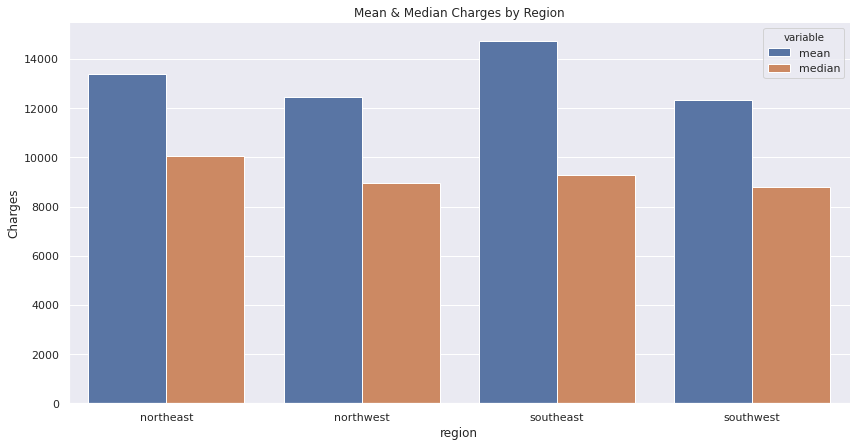

In [301]:
region_charges = df.groupby(['region', 'charges'], as_index=False).mean().groupby('region')['charges'].mean().to_frame()
region_charges.rename(columns={'charges':'mean'}, inplace=True)
region_charges.reset_index()

region_median = df.groupby(['region', 'charges'], as_index=False).median().groupby('region')['charges'].median().to_frame()

region_charges['median'] = region_median['charges']
region_charges = region_charges.reset_index()
region_charges = region_charges.melt(id_vars='region')

fig, ax1 = plt.subplots(figsize=(14, 7))

sns.barplot(x='region', y='value', hue='variable', data=region_charges, ax=ax1)
plt.title('Mean & Median Charges by Region')
plt.ylabel('Charges')
sns.despine(fig)


### AVERAGE PATIENT CHARGES ORGANIZED BY WEIGHT STATUS & REGION

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



Text(0.5, 0.98, 'AVERAGE PATIENT CHARGES BY WEIGHT STATUS, ORGANIZED BY REGION')

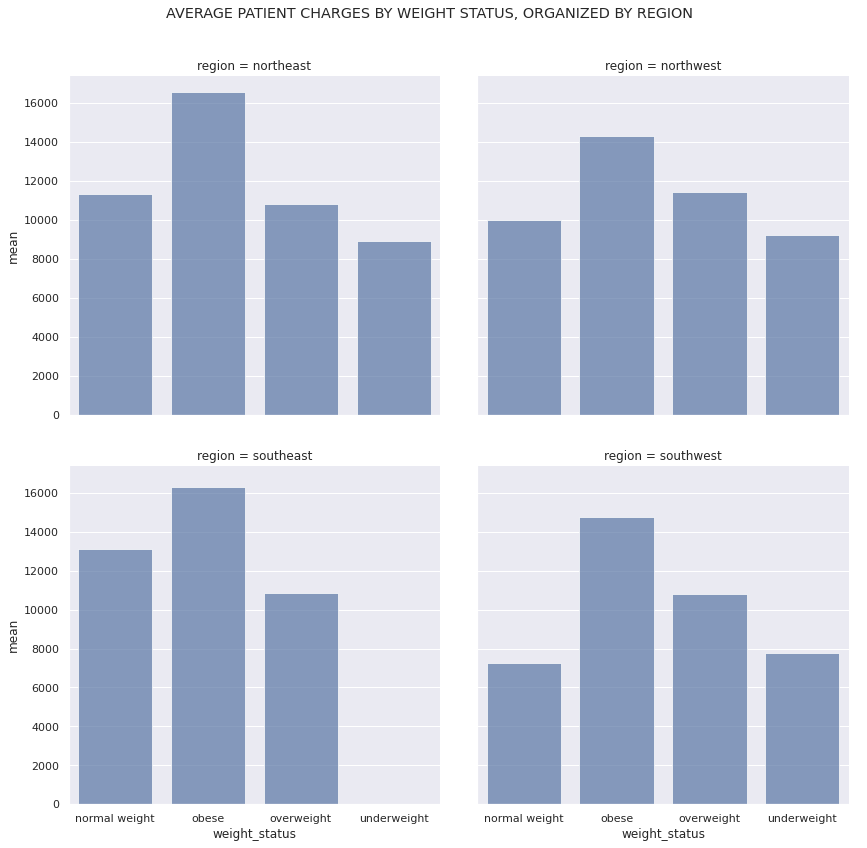

In [302]:
weight_region = df.groupby(['region', 'weight_status'], as_index=False)['charges'].mean()
weight_region.rename(columns={'charges':'mean'}, inplace=True)
weight_region

sns.set(font_scale=1)  
g = sns.FacetGrid(weight_region, col="region", col_wrap=2, height=6)
g.map(sns.barplot, "weight_status", "mean", alpha=.7)
g.fig.subplots_adjust(wspace=.1, hspace=.15)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('AVERAGE PATIENT CHARGES BY WEIGHT STATUS, ORGANIZED BY REGION')


<a id="features"></a>
## **FEATURE SELECTION**

Based on our exploratory data analysis we were able to identify the **smoker**, **bmi**, and **age**, variables as most significant in predicting our target variable. 

In this section we will encode our categorical variables using the LabelEncoder in preparation to run our models. 

In [303]:
from sklearn.preprocessing import LabelEncoder

# sex, female = 0, male = 1
le = LabelEncoder()
le.fit(df.sex.drop_duplicates()) 
df.sex = le.transform(df.sex)

# smoker/non-smoker - non-smoker=0, smoker=1
le.fit(df.smoker.drop_duplicates()) 
df.smoker = le.transform(df.smoker)

#region - Northeast = 0, Northwest = 1, Southeast = 2, Southwest = 3
le.fit(df.region.drop_duplicates()) 
df.region = le.transform(df.region)



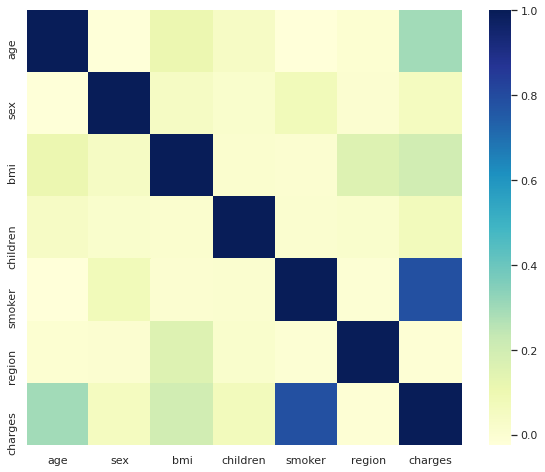

In [304]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='YlGnBu', square=True, ax=ax)

<a id="models"></a>
## **MODEL BUILDING**

We will implement several different models in order to predict our target variable using our selected features.

The models used will consist of:
* Multiple Linear Regression
* Lasso Regression
* Ridge Regression
* Random Forest Regression
* Polynomial Regression 

In [305]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

<a id="lr"></a>
### MULTIPLE LINEAR REGRESSION

In [306]:
X = df.drop(['charges', 'age_cat', 'weight_status', 'region', 'children'], axis = 1)
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

yhat_train = lr.predict(X_train)
yhat_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, yhat_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, yhat_lr))
mae_lr = mean_absolute_error(y_test, yhat_lr)
r2_lr = r2_score(y_test, yhat_lr)
rss_lr = np.mean((yhat_lr - y_test) * 2)
evs_lr = lr.score(X_test, y_test)


print('Intercept: ', lr.intercept_)
print('Coeficient ', lr.coef_)

Intercept:  -11239.832486084832
Coeficient  [  254.284314      29.68735411   314.96997768 23658.69608788]


<a id="ridge"></a>
### RIDGE REGRESSION

In [307]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)
yhat_ridge = ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, yhat_ridge)
rmse_ridge = math.sqrt(mean_squared_error(y_test, yhat_ridge))
mae_ridge = mean_absolute_error(y_test, yhat_ridge)
r2_ridge = r2_score(y_test, yhat_ridge)
rss_ridge = np.mean((yhat_ridge - y_test) * 2)
evs_ridge = ridge.score(X_test, y_test)


print('Intercept: ', ridge.intercept_)
print('Coeficient ', ridge.coef_)

Intercept:  -11221.06824811431
Coeficient  [  254.17604953    33.71257705   314.91644826 23585.30143641]


<a id="lasso"></a>
### LASSO REGRESSION

In [308]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
lasso.fit(X_train, y_train)
yhat_lasso = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, yhat_lasso)
rmse_lasso = math.sqrt(mean_squared_error(y_test, yhat_lasso))
mae_lasso = mean_absolute_error(y_test, yhat_lasso)
r2_lasso = r2_score(y_test, yhat_lasso)
rss_lasso = np.mean((yhat_lasso - y_test) * 2)
evs_lasso = lasso.score(X_test, y_test)

print('Intercept: ', lasso.intercept_)
print('Coeficient ', lasso.coef_)

Intercept:  -11239.025039007314
Coeficient  [  254.28194957    28.95462174   314.96623994 23657.51537436]


<a id="rf"></a>
### RANDOM FOREST REGRESSION

In [309]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

rf = RandomForestRegressor(n_estimators = 100, criterion = 'mse', random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)
yhat_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, yhat_rf)
rmse_rf = math.sqrt(mean_squared_error(y_test, yhat_rf))
mae_rf = mean_absolute_error(y_test, yhat_rf)
r2_rf = r2_score(y_test, yhat_rf)
rss_rf = np.mean((yhat_rf - y_test) * 2)
evs_rf = rf.score(X_test, y_test)

<a id="poly"></a>
### POLYNOMIAL REGRESSION

In [310]:
from sklearn.preprocessing import PolynomialFeatures


pol = PolynomialFeatures(degree = 2)
X_pol = pol.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_train, y_train)

yhat_poly = pol_reg.predict(X_test)

mse_poly = mean_squared_error(y_test, yhat_poly)
rmse_poly = math.sqrt(mean_squared_error(y_test, yhat_poly))
mae_poly = mean_absolute_error(y_test, yhat_poly)
r2_poly = r2_score(y_test, yhat_poly)
rss_poly = np.mean((yhat_poly - y_test) * 2)
evs_poly = pol_reg.score(X_test, y_test)

print(pol_reg.intercept_)
print(pol_reg.coef_)
print(pol_reg.score(X_test, y_test))
print('')



-11239.832486084832
[  254.284314      29.68735411   314.96997768 23658.69608788]
0.7923828990966664



<a id="modeleval"></a>
## MODEL EVALUATION

The **Random Forest Regression Model** is the model that gives us the best results with an R Squared score of 86% and a lower error scores than the other models. 

In [311]:
#MEAN SQUARED ERROR
print('MEAN SQUARED ERROR')
print('Linear Regression | Mean Squared Error: %.2f ' % mse_lr)
print('Ridge Regression | Mean Squared Error: %.2f ' % mse_ridge)
print('Lasso Regression | Mean Squared Error: %.2f ' % mse_lasso)
print('Random Forest | Mean Squared Error: %.2f ' % mse_rf)
print('Polynomial Regression | Mean Squared Error: %.2f ' % mse_poly)
print('')

#ROOT MEAN SQUARED ERROR
print('ROOT MEAN SQUARED ERROR')
print('Linear Regression | Root Mean Squared Error: %.2f ' % rmse_lr)
print('Ridge Regression | Root Mean Squared Error: %.2f ' % rmse_ridge)
print('Lasso Regression | Root Mean Squared Error: %.2f ' % rmse_lasso)
print('Random Forest | Root Mean Squared Error: %.2f ' % rmse_rf)
print('Polynomial Regression | Root Mean Squared Error: %.2f ' % rmse_poly)
print('')

#MEAN ABSOLUTE ERROR
print('MEAN ABSOLUTE ERROR')
print('Linear Regression | Mean Absolute Error: %.2f ' % mae_lr)
print('Ridge Regression | Mean Absolute Error: %.2f ' % mae_ridge)
print('Lasso Regression | Mean Absolute Error: %.2f ' % mae_lasso)
print('Random Forest | Mean Absolute Error: %.2f ' % mae_rf)
print('Polynomial Regression | Mean Absolute Error: %.2f ' % mae_poly)
print('')

#R2 SCORE
print('R2 SCORE')
print('Linear Regression | R2 Score: %.4f ' % r2_lr)
print('Ridge Regression | R2 Score: %.4f ' % r2_ridge)
print('Lasso Regression | R2 Score: %.4f ' % r2_lasso)
print('Random Forest | R2 Score: %.4f ' % r2_rf)
print('Polynomial Regression | R2 Score: %.4f ' % r2_poly)
print('')

#RESIDUAL SUM OF SQUARES
print('RESIDUAL SUM OF SQUARES')
print('Linear Regression | Residual Sum of Squares %.2f ' % rss_lr)
print('Ridge Regression | Residual Sum of Squares %.2f ' % rss_ridge)
print('Lasso Regression | Residual Sum of Squares %.2f ' % rss_lasso)
print('Random Forest | Residual Sum of Squares %.2f ' % rss_rf)
print('Polynomial Regression | Residual Sum of Squares %.2f ' % rss_poly)
print('')

#EXPLAINED VARIANCE SCORE
print('EXPLAINED VARIANCE SCORE')
print('Linear Regression | Explained Variance Score: %.4f ' % evs_lr)
print('Ridge Regression | Explained Variance Score: %.4f ' % evs_ridge)
print('Lasso Regression | Explained Variance Score: %.4f ' % evs_lasso)
print('Random Forest | Explained Variance Score: %.4f ' % evs_rf)
print('Polynomial Regression | Explained Variance Score: %.4f ' % evs_poly)


MEAN SQUARED ERROR
Linear Regression | Mean Squared Error: 32686097.13 
Ridge Regression | Mean Squared Error: 32704209.28 
Lasso Regression | Mean Squared Error: 32686187.91 
Random Forest | Mean Squared Error: 22017828.32 
Polynomial Regression | Mean Squared Error: 32686097.13 

ROOT MEAN SQUARED ERROR
Linear Regression | Root Mean Squared Error: 5717.18 
Ridge Regression | Root Mean Squared Error: 5718.76 
Lasso Regression | Root Mean Squared Error: 5717.18 
Random Forest | Root Mean Squared Error: 4692.32 
Polynomial Regression | Root Mean Squared Error: 5717.18 

MEAN ABSOLUTE ERROR
Linear Regression | Mean Absolute Error: 4003.45 
Ridge Regression | Mean Absolute Error: 4009.98 
Lasso Regression | Mean Absolute Error: 4003.51 
Random Forest | Mean Absolute Error: 2735.80 
Polynomial Regression | Mean Absolute Error: 4003.45 

R2 SCORE
Linear Regression | R2 Score: 0.7924 
Ridge Regression | R2 Score: 0.7923 
Lasso Regression | R2 Score: 0.7924 
Random Forest | R2 Score: 0.8601 


## CONCLUSION

In the United States healthcare continues to be a highly contested issue. The rising costs of healthcare puts many people at financial risk for even the smallest of illnesses. Analysis of this dataset has provided great insight to some of the factors that have a profound effect on the cost of healthcare, chief among them being whether or not a person smokes. 

With this information and information that may be gained in the future, one can hope that individuals will make appropriate decisions regarding their health and that as a society we develop ways to better aid each other in the ways that are needed. 

This notebook will continue to be updated, but please feel free to leave feedback!

Thanks for stopping by, 

Milton